## CISC 614 - Assignment 6
#### Approximate data with higher order polynomials
#### Roman Moser 187700

#### INTRODUCTION
The goal of this assignment is it to find a function that approximates the relationship between hydraulic conductivity and aquifer resistivity. The problem is described in more detail in a study by Vogelgesang, J. A., Holt, N., Schilling, K. E., Gannon, M., & Tassier-Surine, S. (2019). One reason to approximate data with a function is that it might be very costly to obtain additional measurement samples whereas estimations with a model based on a good dataset come for free. In this assignment we use different order polynomials to approximate the data and elaborate on the reasoning behind the choices and methods used. The data set used is shown in the table below:

Resistivity (ohm-m) | Conductivity (m/day) |

+---------------------+----------------------+

|         11.3        |         52.7         |

|         49.5        |         28.8         |

|         88.0        |         57.2         |

|        193.1        |        108.9         |

|        247.6        |         40.0         |

|        603.4        |        197.0         |

|        792.0        |        239.1         |

|        908.3        |        194.7         |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
data = pd.DataFrame([[11.3, 52.7], [49.5, 28.8], [88.0, 57.2], [193.1, 108.9], [247.6, 40.0],
                    [603.4, 197.0], [792.0, 239.1], [908.3, 194.7]], columns=['res', 'cond'])

In [3]:
def polynomial(x, coeffs):
    """
    Function that calculated the corresponding point y as f(x) for
    a polynomial f with the coefficients "coeff"
    """
    y = 0
    for i, coeff in enumerate(coeffs[::-1]):
        y += coeff * x**i
    return y

### Submodel #1 - Interpolating Polynomial

To find the one unique polynomial that is guaranteed to pass through all data points, I am making use of the **scipy.interpolate** package and the **lagrange** method. I then create an array for the independent variable *resistivity* (x) of 1000 evenly spaced points between 0 and 950 and calculate the corresponding *conductivity* (y) according to the unique polynomial.

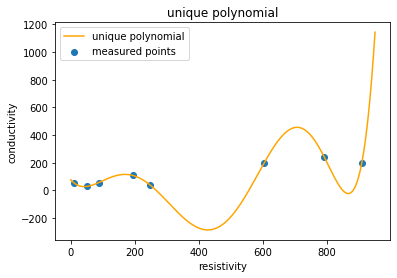

In [4]:
f = interpolate.lagrange(data.res, data.cond)
x_ = np.linspace(0, 950, 1000)
y_ = []
for x in x_:
    y_.append(polynomial(x, f.coeffs))
    
plt.plot(x_, y_, color='orange')
plt.scatter(data.res, data.cond)
plt.legend(['unique polynomial', 'measured points'])
plt.title('unique polynomial')
plt.xlabel('resistivity')
plt.ylabel('conductivity')
plt.show()

As shown in the plot above, we achieved the goal of finding a polynomial (the only one of order n-1) that passes each measured data point. However, we seem to be significantly overfitting the data as the polynomial includes up and down swings (especially between the last four data points) that are not to be expected when observing the data. Additionally, the polynomial suggests that conductivity approaches infinity quickly after it passes through the last data point.

### Submodel #2 - Low-order best-fit polynomial
Next, we try to find a lower order polynomial that best approximates the data. To achieve this we first use the divided difference method to find the order of the polynomial and then use least squares regression (with the *numpy.polyfit* package) to approximate the data.

In [5]:
def divided_differences(x, y, n_derivatives=3):
    def new_x(x):
        return [(x[i-1] + x[i]) / 2 for i in range(1, len(x))]
    divided_diffs = []
    for i in range(n_derivatives):
        x_diff = np.array([x[i] - x[i-1] for i in range(1, len(x))])
        y_diff = np.array([y[i] - y[i-1] for i in range(1, len(y))])
        y = np.round(y_diff / x_diff, 5)
        divided_diffs.append(y)
        x = new_x(x)
    return divided_diffs

divided_diffs = divided_differences(data.res, data.cond, n_derivatives=3)
for i, diffs in enumerate(divided_diffs):
    print('divided differences {}: {}'.format(i+1, diffs))

divided differences 1: [-0.62565  0.73766  0.49191 -1.26422  0.44126  0.22322 -0.38177]
divided differences 2: [ 0.03555 -0.00342 -0.02201  0.00831 -0.0008  -0.00397]
divided differences 3: [-7.1e-04 -2.5e-04  2.1e-04 -4.0e-05 -1.0e-05]


In [6]:
# format table of divided differences for display:
print('Divided difference for 1st, 2nd and 3rd derivative:')
delta1 = np.array(['-0.62565', '', '0.73766', '', '0.49191', '', '-1.26422', '', '0.44126',
                  '', '0.22322', '', '-0.38177'])
delta2 = np.array(['', '0.03555', '', '-0.00342', '', '-0.02201', '', '0.00831', '', '-0.0008',
                  '', '-0.00397', ''])
delta3 = np.array(['', '', '-7.1e-04', '', '-2.5e-04', '', '2.1e-04', '', '-4.0e-05', '', 
                   '-1.0e-05', '', ''])
table = pd.DataFrame(np.array([delta1, delta2, delta3]).T, columns=['delta 1', 'delta 2', 'delta 3'],
               index=[''] * 13)
table

Divided difference for 1st, 2nd and 3rd derivative:


,delta 1,delta 2,delta 3
,-0.62565,,
,,0.03555,
,0.73766,,-7.1e-04
,,-0.00342,
,0.49191,,-2.5e-04
,,-0.02201,
,-1.26422,,2.1e-04
,,0.00831,
,0.44126,,-4.0e-05
,,-0.0008,


The divided differences table above shows that the values are close to zeros starting with the 2nd iteration (~10^-2). With the third iteration they differ from zero by a magnitude of around 10^-4. These results suggest that a second order polynomial might very likely approximate the data well without overfitting. To test this hypothesis, we plot both, the approximation with the second and the third order polynomial below.

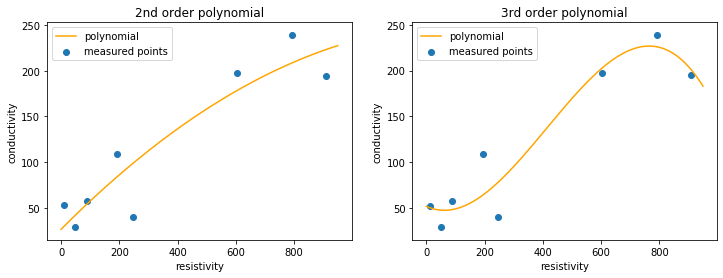

In [7]:
coeffs_2nd = np.polyfit(data.res, data.cond, 2)
coeffs_3rd = np.polyfit(data.res, data.cond, 3)

y_2nd_order, y_3rd_order = [], []
for x in x_:
    y_2nd_order.append(polynomial(x, coeffs_2nd))
    y_3rd_order.append(polynomial(x, coeffs_3rd))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_, y_2nd_order, color='orange')
plt.scatter(data.res, data.cond)
plt.legend(['polynomial', 'measured points'])
plt.title('2nd order polynomial')
plt.xlabel('resistivity')
plt.ylabel('conductivity')
plt.subplot(1, 2, 2)
plt.plot(x_, y_3rd_order, color='orange')
plt.scatter(data.res, data.cond)
plt.legend(['polynomial', 'measured points'])
plt.title('3rd order polynomial')
plt.xlabel('resistivity')
plt.ylabel('conductivity')
plt.show()

#### CONCLUSIONS
As seen in the first part of the assignment, a unique polynomial of order (n-1) that goes through each measured data point, clearly overfits the data. We therefore had to choose a polynomial of lower order. The order we determined with the method divided differences in which we divide the difference between each two subsequent data points on the y-axis (conductivity) by the difference on the x-axis (resistivity). We repeat this process until the divided differences approach 0 and choose the number iterations as the order of the polynomial to approximate the data. To find the coefficients of the polynomial we used least squares regression.

The plots above show that the second order polynomial approximates the data pretty well. The third order polynomial on the right side better approximates especially the last three data points with a resistivity of >600, however, it seems to already overfit the data assuming the conductivity does not start to decrease again at a certain point (~800 ohm-m resistivity). In this case, to be sure whether the second or the third order polynomial ist the better one to use, some additional information would be necessary. This information could be domain knowledge (does conductivity decrease with increasing resistivity at a certain point?) or information on the measurement equipment used to obtain the data (what is the expected error?).

#### REFERENCES
[1] Vogelgesang, J. A., Holt, N., Schilling, K. E., Gannon, M., & Tassier-Surine, S. (2019). Using high-resolution electrical resistivity to estimate hydraulic conductivity and improve characterization of alluvial aquifers. Journal of Hydrology